# 17. Multiple regression

Essentially we'll be predicting house prices using 2 methods:

1. MULTIPLE LINEAR REGRESSION

This method involves creating a formula (linear regression) to predict the sale price of houses using multiple factors (attributes) such as the size of the first floor, second floor, garage area, etc.

2. NEAREST NEIGHBOURS FOR REGRESSION

An alternative approach where instead of using a formula, we predict the price of a house by looking at the prices of houses that are similar to it.

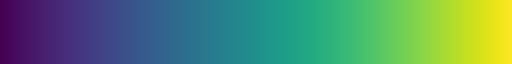

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries for regression
import statsmodels.formula.api as smf

# Set style for seaborn plots
sns.set_style('dark')
sns.color_palette("viridis", as_cmap=True)

In [2]:
house = pd.read_csv('house.csv')
house = house.rename(columns={
    'SalePrice': 'sale_price',
    '1st Flr SF': '1st_flr',
    '2nd Flr SF': '2nd_flr',
    'Total Bsmt SF': 'bsmt',
    'Garage Area': 'garage',
    'Wood Deck SF': 'wood_deck',
    'Open Porch SF': 'open_porch',
    'Lot Area': 'lot',
    'Year Built': 'year_built',
    'Yr Sold': 'year_sold'
})
house = house[['sale_price', '1st_flr', '2nd_flr', 'bsmt', 'garage', 'wood_deck', 'open_porch', 'lot', 'year_built', 'year_sold']]
house.head(1)

,sale_price,1st_flr,2nd_flr,bsmt,garage,wood_deck,open_porch,lot,year_built,year_sold
0,215000,1656,0,1080.0,528.0,210,62,31770,1960,2010


A histogram of sale prices shows a large amount of variability and a distribution that is clearly not normal. A long tail to the right contains a few houses that had very high prices. The short left tail does not contain any houses that sold for less than $35,000.

<Axes: xlabel='sale_price', ylabel='Count'>

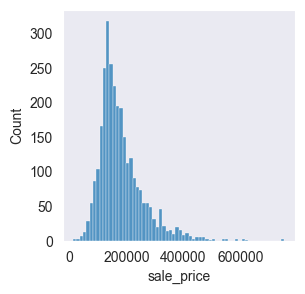

In [3]:
plt.figure(figsize = (3, 3))
sns.histplot(data = house,
             x = 'sale_price')

In [ ]:
plt.figure(figsize = (3, 3))
sns.histplot(data = house,
    kdfkdfkhd

## Correlation

In [4]:
house.corr().head(1).round(4)

,sale_price,1st_flr,2nd_flr,bsmt,garage,wood_deck,open_porch,lot,year_built,year_sold
sale_price,1.0,0.6217,0.2694,0.6323,0.6404,0.3271,0.313,0.2665,0.5584,-0.0306


However, combining attributes can provide higher correlation. In particular, if we sum the first floor and second floor areas, the result has a higher correlation than any single attribute alone.

## Generating a test set

In [5]:
house_shuffled = house.sample(frac = 1, replace = False)
split_index = len(house_shuffled) // 2
training_set = house_shuffled[:split_index]
testing_set = house_shuffled[split_index:]

## Multiple linear regression

### 1. Understanding how slopes = weights & their affects on predicted y

In [6]:
# Assuming 'sale_price' is the correct column name, but make sure to check the actual column names in your DataFrame.
example_row = house.drop(['sale_price'], axis=1).iloc[0]


In [7]:
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)

Using slopes: [ 9.77581339  9.34694567  9.5111019  11.45980413 11.27927041  9.70169537
  9.46341875 10.62225996  8.62286476]


In [8]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

The predict function takes these slopes and multiplies them by the corresponding attribute values in example_row. The sum of these products gives the estimated sale price.

In [9]:
print('Actual sale price:', house['sale_price'].iloc[0])
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 215000
Predicted sale price using random slopes: 374286.06691360136


The result is an estimated sale price, which can be compared to the actual sale price to assess whether the slopes provide accurate predictions. Since the example_slopes above were chosen at random, we should not expect them to provide accurate predictions at all.

### 2. Least square regressions

The next step in performing multiple regression is to define the least squares objective. We perform the prediction for each row in the training set, and then compute the root mean squared error (RMSE) of the predictions from the actual prices.

In [10]:
# Assuming 'training_set' is your training DataFrame
train_prices = training_set['sale_price'].values
train_attributes = training_set.drop(['sale_price'], axis=1)

train_attributes_filled = train_attributes.fillna(train_attributes.mean())

# Ensure example_slopes matches the number of remaining attributes
example_slopes = np.random.normal(10, 1, len(train_attributes.columns))

def predict(slopes, row):
    return sum(slopes * np.array(row))

def rmse(slopes, attributes, prices):
    errors = [(predict(slopes, attributes.iloc[i, :]) - prices[i]) ** 2 for i in range(len(prices))]
    return np.sqrt(np.mean(errors))

def rmse_train(slopes):
    return rmse(slopes, train_attributes_filled, train_prices)

rmse_train(example_slopes)

89087.32460321065

Finally, we use the minimize function to find the slopes with the lowest RMSE. Since the function we want to minimize, rmse_train, takes an array instead of a number, we must pass the array=True argument to minimize. When this argument is used, minimize also requires an initial guess of the slopes so that it knows the dimension of the input array. Finally, to speed up optimization, we indicate that rmse_train is a smooth function using the smooth=True attribute. Computation of the best slopes may take several minutes.

In [11]:
from scipy.optimize import minimize

# Set bounds for the slopes, if needed
bounds = [(None, None)] * len(example_slopes)

# Use minimize to find the best slopes
best_slopes = minimize(rmse_train, x0=example_slopes, bounds=bounds)['x']

# Display the best slopes
print('The best slopes for the training set:')
for label, slope in zip(train_attributes.columns, best_slopes):
    print(f'{label}\t{slope}')

# Calculate and display the RMSE using the best slopes
best_rmse = rmse_train(best_slopes)
print('RMSE of all training examples using the best slopes:', best_rmse)

The best slopes for the training set:
1st_flr	66.81014125551881
2nd_flr	65.5419655100946
bsmt	29.030078327882073
garage	58.75061686291079
wood_deck	49.2644691605095
open_porch	21.072327502542507
lot	0.5483520154972276
year_built	732.6400176420666
year_sold	-713.8968896496317
RMSE of all training examples using the best slopes: 42441.05549506805


### 3. Existing package

In [12]:
model = 'sale_price ~ Q("1st_flr") + Q("2nd_flr") + bsmt + garage + wood_deck + open_porch + lot + year_built + year_sold'
regression = smf.ols(formula = model, data = house).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     907.6
Date:                Mon, 08 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:37:58   Log-Likelihood:                -35252.
No. Observations:                2928   AIC:                         7.052e+04
Df Residuals:                    2918   BIC:                         7.058e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.184e+05   1.16e+06     -0.102      0.919   -2.39e+06    2.16e+06
Q("1st_flr")    71.8469      3.497     20.546      0.000      64.990      78.703
Q("2nd_flr")    68.3078      2.006     34.053      0.000      64.375      72.241
bsmt            38.6885      3.018     12.818      0.000      32.770      44.607
garage          62.7917      4.631     13.559      0.000      53.711      71.872
wood_deck       38.5272      6.378      6.041      0.000      26.022      51.033
open_porch      14.9671     12.141      1.233      0.218      -8.839      38.773
lot              0.3054      0.104      2.934      0.003       0.101       0.510
year_built     679.6490     30.102     22.578      0.000     620.626     738.672
year_sold     -609.9535    576.727     -1.058      0.290   -1740.787     520.880
==============================================================================
Omnibus:                     1242.185   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           135089.991
Skew:                          -1.030   Prob(JB):                         0.00
Kurtosis:                      36.212   Cond. No.                     2.01e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""